In [2]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import os

sys.path.append(os.path.abspath('..'))
project_root = os.path.dirname(os.path.dirname(os.path.abspath('.')))
if project_root not in sys.path:
    sys.path.append(project_root)

from train.meta_reasoner.config import MODEL_OUTPUT_DIR, MODEL_NAME
from src.logger import logger

sns.set_theme(style="whitegrid")

In [8]:
try:
    # Load the artifact
    model_path = os.path.join(MODEL_OUTPUT_DIR, MODEL_NAME)
    weights_artifact = joblib.load(model_path)
    logger.info(f"Loaded meta-reasoner weights from {model_path}")
    
    # Inspect the artifact structure
    print("Artifact type:", type(weights_artifact))
    print("Artifact keys:", weights_artifact.keys() if hasattr(weights_artifact, 'keys') else "Not a dictionary")
    
    if isinstance(weights_artifact, dict):
        # Convert the dictionary to a pandas DataFrame for easier plotting
        weights_df = pd.DataFrame.from_dict(weights_artifact, orient='index')
        weights_df = weights_df.reset_index().rename(columns={'index': 'topic'})
        
        print("\nLearned Reasoner Weights:")
        print("DataFrame shape:", weights_df.shape)
        print("DataFrame columns:", weights_df.columns.tolist())
        display(weights_df.head())
        
        # Check data types
        print("\nData types:")
        print(weights_df.dtypes)

except FileNotFoundError as e:
    logger.error(f"Error: {e}. Please run the full training pipeline first.")

2025-10-08 09:01:43,303 - AgenticReasoningPipeline - INFO - Loaded meta-reasoner weights from e:\agentic-reasoning-engine\models\meta_reasoner.pkl (359996049.py:5)
Artifact type: <class 'dict'>
Artifact keys: dict_keys(['Optimization of actions and planning', 'Spatial reasoning', 'Operation of mechanisms', 'Classic riddles', 'Sequence solving', 'Lateral thinking', 'Logical traps'])

Learned Reasoner Weights:
DataFrame shape: (7, 4)
DataFrame columns: ['topic', 'classifier', 'analogy', 'llm']


,topic,classifier,analogy,llm
0,Optimization of actions and planning,0.334545,0.345455,0.320000
1,Spatial reasoning,0.359184,0.306122,0.334694
2,Operation of mechanisms,0.333333,0.313725,0.352941
3,Classic riddles,0.333333,0.333333,0.333333
4,Sequence solving,0.333333,0.333333,0.333333



Data types:
topic          object
classifier    float64
analogy       float64
llm           float64
dtype: object


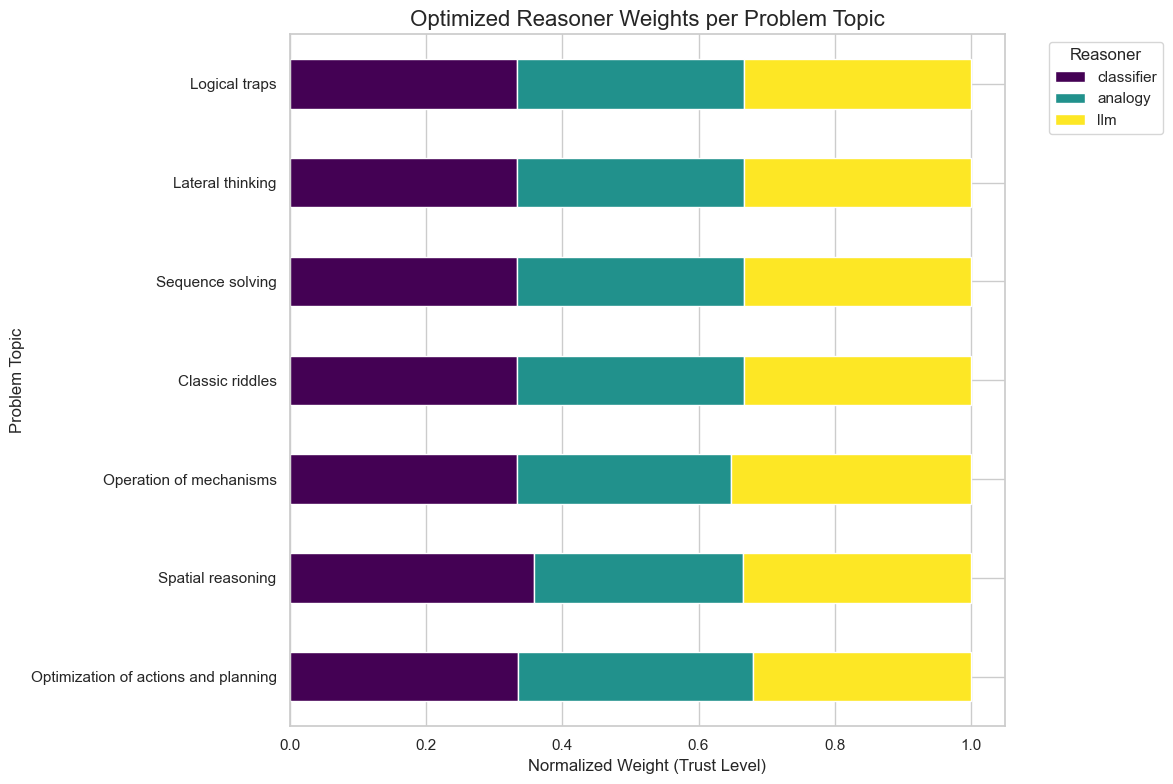

In [9]:
# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))

weights_df.set_index('topic').plot(
    kind='barh', 
    stacked=True, 
    colormap='viridis',
    ax=ax
)

ax.set_title('Optimized Reasoner Weights per Problem Topic', fontsize=16)
ax.set_xlabel('Normalized Weight (Trust Level)')
ax.set_ylabel('Problem Topic')
ax.legend(title='Reasoner', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [10]:
def get_strategy_weights(topic: str):
    """Retrieves the learned weights for a given problem topic."""
    if topic in weights_artifact:
        return weights_artifact[topic]
    else:
        # Return a default, uniform weighting for unknown topics
        logger.warning(f"Topic '{topic}' not found. Returning default weights.")
        return {'classifier': 0.33, 'analogy': 0.33, 'llm': 0.34}

print("--- Running Inference Test ---")

test_topic_1 = "Spatial reasoning"
weights1 = get_strategy_weights(test_topic_1)
print(f"Weights for '{test_topic_1}': {weights1}")

test_topic_2 = "Optimization of actions and planning"
weights2 = get_strategy_weights(test_topic_2)
print(f"Weights for '{test_topic_2}': {weights2}")

--- Running Inference Test ---
Weights for 'Spatial reasoning': {'classifier': 0.3591836734693878, 'analogy': 0.30612244897959184, 'llm': 0.3346938775510204}
Weights for 'Optimization of actions and planning': {'classifier': 0.33454545454545453, 'analogy': 0.34545454545454546, 'llm': 0.32}


In [11]:
def analyze_weight_patterns():
    """Analyze patterns in the learned weights across topics."""
    print("--- Weight Pattern Analysis ---")
    
    # Check if we have numeric columns for analysis
    numeric_columns = weights_df.select_dtypes(include=[np.number]).columns.tolist()
    print("Numeric columns available:", numeric_columns)
    
    if len(numeric_columns) == 0:
        print("No numeric columns found for analysis. Checking data structure...")
        # Try to convert object columns to numeric
        for col in weights_df.columns:
            if col != 'topic':
                try:
                    weights_df[col] = pd.to_numeric(weights_df[col])
                    print(f"Converted column '{col}' to numeric")
                except:
                    print(f"Column '{col}' cannot be converted to numeric")
        
        numeric_columns = weights_df.select_dtypes(include=[np.number]).columns.tolist()
    
    if numeric_columns:
        # Calculate average weights across all topics
        avg_weights = weights_df[numeric_columns].mean()
        print("\nAverage Weights Across All Topics:")
        for reasoner, weight in avg_weights.items():
            print(f"  {reasoner}: {weight:.3f}")
        
        # Find dominant reasoner for each topic
        weights_df['dominant_reasoner'] = weights_df[numeric_columns].idxmax(axis=1)
        weights_df['dominant_weight'] = weights_df[numeric_columns].max(axis=1)
        
        print(f"\nDominant Reasoner Distribution:")
        dominant_counts = weights_df['dominant_reasoner'].value_counts()
        for reasoner, count in dominant_counts.items():
            percentage = (count / len(weights_df)) * 100
            print(f"  {reasoner}: {count} topics ({percentage:.1f}%)")
    else:
        print("No numeric data available for pattern analysis")
    
    return weights_df

# Analyze weight patterns
enhanced_weights_df = analyze_weight_patterns()
if 'dominant_reasoner' in enhanced_weights_df.columns:
    display(enhanced_weights_df[['topic', 'dominant_reasoner', 'dominant_weight']])

--- Weight Pattern Analysis ---
Numeric columns available: ['classifier', 'analogy', 'llm']

Average Weights Across All Topics:
  classifier: 0.337
  analogy: 0.328
  llm: 0.334

Dominant Reasoner Distribution:
  classifier: 5 topics (71.4%)
  analogy: 1 topics (14.3%)
  llm: 1 topics (14.3%)


,topic,dominant_reasoner,dominant_weight
0,Optimization of actions and planning,analogy,0.345455
1,Spatial reasoning,classifier,0.359184
2,Operation of mechanisms,llm,0.352941
3,Classic riddles,classifier,0.333333
4,Sequence solving,classifier,0.333333
5,Lateral thinking,classifier,0.333333
6,Logical traps,classifier,0.333333


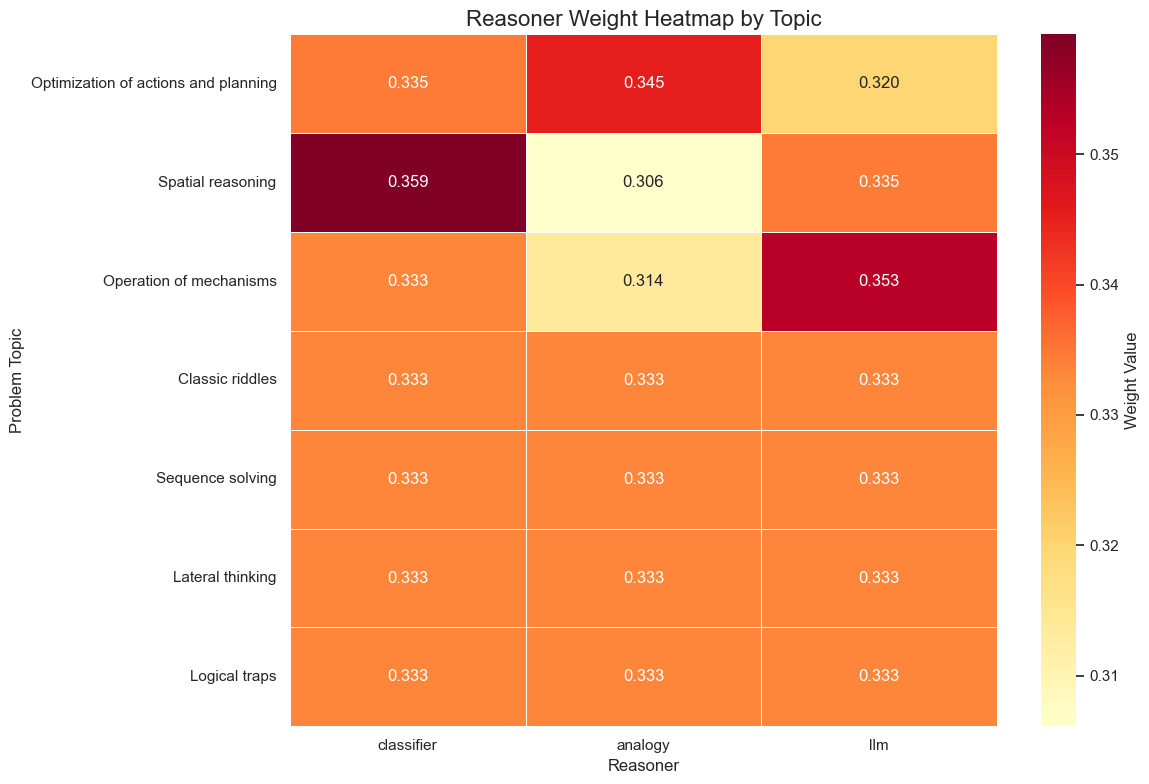

HEATMAP INSIGHTS:
Darker colors indicate higher weights (more trust)
Look for patterns where certain reasoners dominate specific topic clusters


In [13]:
def create_weight_heatmap():
    """Create a heatmap to visualize weight patterns across topics."""
    # Prepare data for heatmap - only numeric columns
    numeric_columns = weights_df.select_dtypes(include=[np.number]).columns.tolist()
    
    if 'dominant_reasoner' in numeric_columns:
        numeric_columns.remove('dominant_reasoner')
    if 'dominant_weight' in numeric_columns:
        numeric_columns.remove('dominant_weight')
    
    if not numeric_columns:
        print("No numeric columns available for heatmap")
        return
    
    heatmap_data = weights_df.set_index('topic')[numeric_columns]
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        heatmap_data, 
        annot=True, 
        cmap='YlOrRd', 
        cbar_kws={'label': 'Weight Value'},
        linewidths=0.5,
        fmt='.3f'  # Format annotations to 3 decimal places
    )
    plt.title('Reasoner Weight Heatmap by Topic', fontsize=16)
    plt.xlabel('Reasoner')
    plt.ylabel('Problem Topic')
    plt.tight_layout()
    plt.show()
    
    # Print insights
    print("HEATMAP INSIGHTS:")
    print("Darker colors indicate higher weights (more trust)")
    print("Look for patterns where certain reasoners dominate specific topic clusters")

# Create heatmap
create_weight_heatmap()

In [15]:
def analyze_weight_statistics():
    """Calculate detailed statistics about the weight distributions."""
    print("--- Weight Distribution Statistics ---")
    
    # Get numeric columns
    numeric_columns = weights_df.select_dtypes(include=[np.number]).columns.tolist()
    if 'dominant_weight' in numeric_columns:
        numeric_columns.remove('dominant_weight')
    
    if not numeric_columns:
        print("No numeric weight columns available for statistics")
        return
    
    # Calculate statistics for each reasoner
    stats_df = weights_df[numeric_columns].describe()
    print("\nWeight Statistics:")
    display(stats_df)
    
    # Identify outlier topics (where one reasoner has very high/low weight)
    print("\nOUTLIER ANALYSIS:")
    
    if 'dominant_reasoner' in weights_df.columns and 'dominant_weight' in weights_df.columns:
        # High confidence topics (dominant weight > 0.8)
        high_confidence = weights_df[weights_df['dominant_weight'] > 0.8]
        if not high_confidence.empty:
            print("High Confidence Topics (dominant weight > 0.8):")
            for _, row in high_confidence.iterrows():
                print(f"  {row['topic']}: {row['dominant_reasoner']} ({row['dominant_weight']:.3f})")
        else:
            print("No topics with extremely high confidence in single reasoner")
    
    # Balanced topics (all weights between 0.2 and 0.5)
    balanced_mask = (weights_df[numeric_columns] > 0.2).all(axis=1) & (weights_df[numeric_columns] < 0.5).all(axis=1)
    balanced_topics = weights_df[balanced_mask]
    if not balanced_topics.empty:
        print(f"\nBalanced Topics ({len(balanced_topics)} topics with weights 0.2-0.5):")
        for topic in balanced_topics['topic']:
            print(f"  {topic}")

# Analyze statistics
analyze_weight_statistics()

--- Weight Distribution Statistics ---

Weight Statistics:


,classifier,analogy,llm
count,7.000000,7.000000,7.000000
mean,0.337199,0.328377,0.334424
std,0.009705,0.013539,0.009624
min,0.333333,0.306122,0.320000
25%,0.333333,0.323529,0.333333
50%,0.333333,0.333333,0.333333
75%,0.333939,0.333333,0.334014
max,0.359184,0.345455,0.352941



OUTLIER ANALYSIS:
No topics with extremely high confidence in single reasoner

Balanced Topics (7 topics with weights 0.2-0.5):
  Optimization of actions and planning
  Spatial reasoning
  Operation of mechanisms
  Classic riddles
  Sequence solving
  Lateral thinking
  Logical traps


In [16]:
def simulate_strategic_decisions():
    """Simulate how the meta-reasoner would combine multiple reasoner outputs."""
    print("--- Strategic Decision Simulation ---")
    
    # Mock reasoner outputs (confidence scores between 0-1)
    mock_outputs = {
        'classifier': 0.85,  # High confidence in classification
        'analogy': 0.72,     # Medium confidence in analogy
        'llm': 0.63          # Lower confidence in LLM
    }
    
    # Use actual topics from our data
    if 'topic' in weights_df.columns:
        test_topics = weights_df['topic'].head(3).tolist()
    else:
        test_topics = ['Spatial reasoning', 'Optimization', 'Logical deduction']
    
    for topic in test_topics:
        weights = get_strategy_weights(topic)
        
        # Calculate weighted average using only available weights
        weighted_score = 0
        total_weight = 0
        
        for reasoner, output in mock_outputs.items():
            if reasoner in weights:
                weighted_score += output * weights[reasoner]
                total_weight += weights[reasoner]
        
        if total_weight > 0:
            weighted_score /= total_weight  # Normalize
        
        print(f"\nTopic: {topic}")
        print(f"Weights: {weights}")
        print(f"Mock outputs: {mock_outputs}")
        print(f"Final weighted score: {weighted_score:.3f}")
        
        # Decision threshold
        if weighted_score > 0.7:
            decision = "ACCEPT"
        else:
            decision = "REJECT or SEEK_HUMAN_HELP"
        
        print(f"Decision: {decision}")

# Run simulation
simulate_strategic_decisions()

--- Strategic Decision Simulation ---

Topic: Optimization of actions and planning
Weights: {'classifier': 0.33454545454545453, 'analogy': 0.34545454545454546, 'llm': 0.32}
Mock outputs: {'classifier': 0.85, 'analogy': 0.72, 'llm': 0.63}
Final weighted score: 0.735
Decision: ACCEPT

Topic: Spatial reasoning
Weights: {'classifier': 0.3591836734693878, 'analogy': 0.30612244897959184, 'llm': 0.3346938775510204}
Mock outputs: {'classifier': 0.85, 'analogy': 0.72, 'llm': 0.63}
Final weighted score: 0.737
Decision: ACCEPT

Topic: Operation of mechanisms
Weights: {'classifier': 0.33333333333333337, 'analogy': 0.3137254901960785, 'llm': 0.35294117647058826}
Mock outputs: {'classifier': 0.85, 'analogy': 0.72, 'llm': 0.63}
Final weighted score: 0.732
Decision: ACCEPT
